In [32]:
#Load the required Python libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
# Define file paths
orders_path = "/kaggle/input/jar-datasets/datasets/List_of_Orders_55FFC79CF8.csv"
order_details_path = "/kaggle/input/jar-datasets/datasets/Order_Details_19795F61CF.csv"
sales_target_path = "/kaggle/input/jar-datasets/datasets/Sales_target_DD2E9B96A0.csv"

# Load datasets
orders_df = pd.read_csv(orders_path)
order_details_df = pd.read_csv(order_details_path)
sales_target_df = pd.read_csv(sales_target_path)

# Display first few rows of each dataset
orders_df.head(), order_details_df.head(), sales_target_df.head()


(  Order ID  Order Date CustomerName           State       City
 0  B-25601  01-04-2018       Bharat         Gujarat  Ahmedabad
 1  B-25602  01-04-2018        Pearl     Maharashtra       Pune
 2  B-25603  03-04-2018        Jahan  Madhya Pradesh     Bhopal
 3  B-25604  03-04-2018       Divsha       Rajasthan     Jaipur
 4  B-25605  05-04-2018      Kasheen     West Bengal    Kolkata,
   Order ID  Amount   Profit  Quantity     Category      Sub-Category
 0  B-25601 1275.00 -1148.00         7    Furniture         Bookcases
 1  B-25601   66.00   -12.00         5     Clothing             Stole
 2  B-25601    8.00    -2.00         3     Clothing       Hankerchief
 3  B-25601   80.00   -56.00         4  Electronics  Electronic Games
 4  B-25602  168.00  -111.00         2  Electronics            Phones,
   Month of Order Date   Category   Target
 0              Apr-18  Furniture 10400.00
 1              May-18  Furniture 10500.00
 2              Jun-18  Furniture 10600.00
 3              Jul-18

In [34]:
# Convert 'Order Date' to datetime format
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], format='%d-%m-%Y')

# Extract Month-Year for grouping
orders_df['Month-Year'] = orders_df['Order Date'].dt.to_period('M')


In [35]:
# Merge orders with order details
merged_df = pd.merge(order_details_df, orders_df, on='Order ID')

# Convert 'Month-Year' to string for easier merging
sales_target_df['Month of Order Date'] = sales_target_df['Month of Order Date'].astype(str)
merged_df['Month-Year'] = merged_df['Month-Year'].astype(str)

# Merge with sales target data
final_df = pd.merge(merged_df, sales_target_df, left_on=['Month-Year', 'Category'], right_on=['Month of Order Date', 'Category'], how='left')

# Drop duplicate 'Month of Order Date' column
final_df.drop(columns=['Month of Order Date'], inplace=True)

# Display first few rows
final_df.head()


,Order ID,Amount,Profit,Quantity,Category,Sub-Category,Order Date,CustomerName,State,City,Month-Year,Target
0,B-25601,1275.00,-1148.00,7,Furniture,Bookcases,2018-04-01,Bharat,Gujarat,Ahmedabad,2018-04,NaN
1,B-25601,66.00,-12.00,5,Clothing,Stole,2018-04-01,Bharat,Gujarat,Ahmedabad,2018-04,NaN
2,B-25601,8.00,-2.00,3,Clothing,Hankerchief,2018-04-01,Bharat,Gujarat,Ahmedabad,2018-04,NaN
3,B-25601,80.00,-56.00,4,Electronics,Electronic Games,2018-04-01,Bharat,Gujarat,Ahmedabad,2018-04,NaN
4,B-25602,168.00,-111.00,2,Electronics,Phones,2018-04-01,Pearl,Maharashtra,Pune,2018-04,NaN


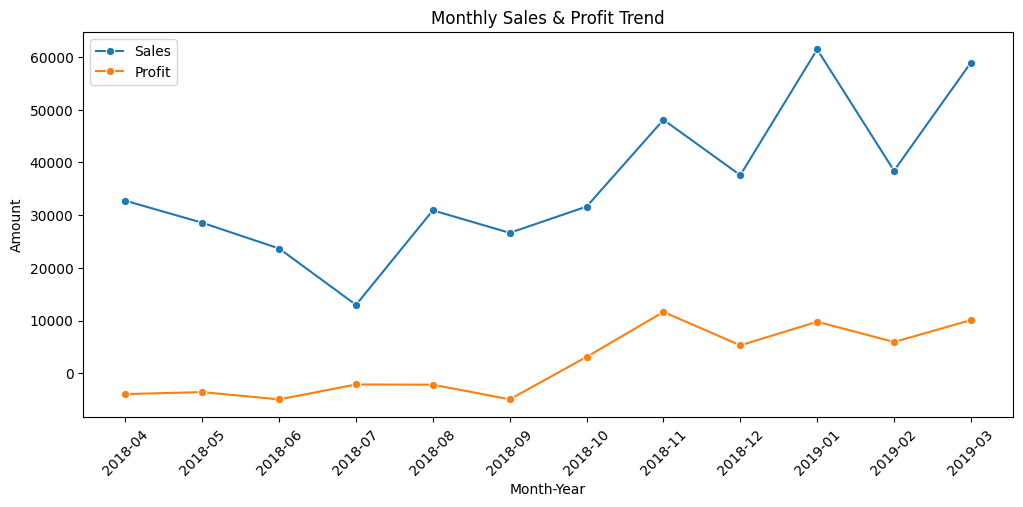

In [36]:
#A. Total Monthly Sales & Profit

monthly_sales = final_df.groupby('Month-Year')[['Amount', 'Profit']].sum().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_sales, x='Month-Year', y='Amount', marker='o', label='Sales')
sns.lineplot(data=monthly_sales, x='Month-Year', y='Profit', marker='o', label='Profit')

plt.xticks(rotation=45)
plt.title("Monthly Sales & Profit Trend")
plt.legend()
plt.show()


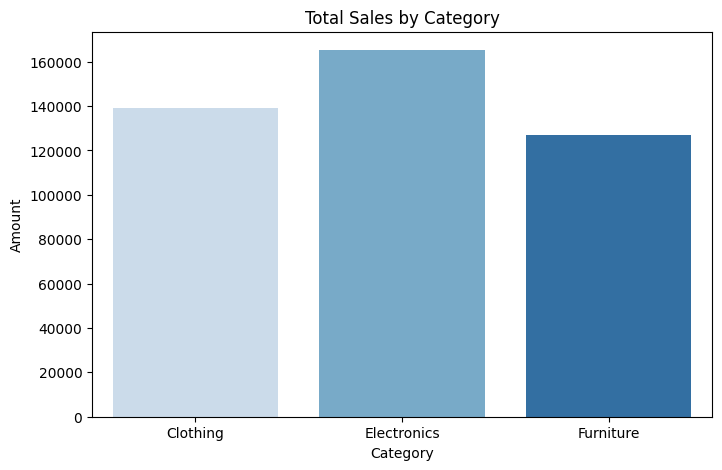

In [37]:
#B. Category-Wise Sales & Profit

category_sales = final_df.groupby('Category')[['Amount', 'Profit']].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='Category', y='Amount', palette='Blues')
plt.title("Total Sales by Category")
plt.show()


  Month-Year     Category   Amount Month of Order Date   Target
0    2018-04     Clothing 13478.00             2018-04 12000.00
1    2018-04  Electronics 11127.00             2018-04  9000.00
2    2018-04    Furniture  8121.00             2018-04 10400.00
3    2018-05     Clothing  9518.00             2018-05 12000.00
4    2018-05  Electronics 12807.00             2018-05  9000.00


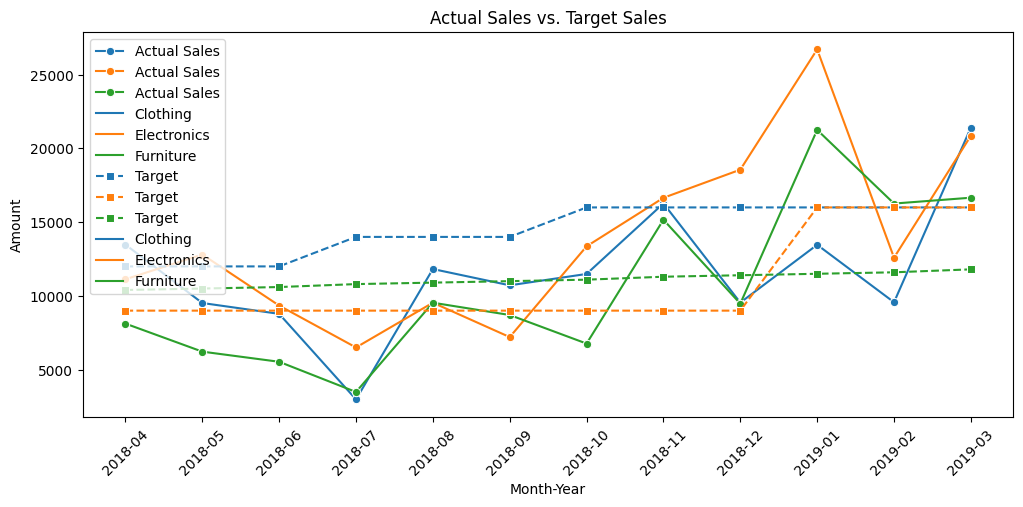

In [41]:
#C. Sales Target vs. Actual Sales

# Convert 'Month of Order Date' to datetime format and then to 'YYYY-MM'
sales_target_df['Month of Order Date'] = pd.to_datetime(sales_target_df['Month of Order Date'], format='%b-%y').dt.strftime('%Y-%m')

# Now, merge the data
comparison_df = pd.merge(category_monthly_sales, sales_target_df, 
                         left_on=['Month-Year', 'Category'], 
                         right_on=['Month of Order Date', 'Category'], 
                         how='inner')

print(comparison_df.head())  # Check if the DataFrame has merged correctly

# Plot the data
plt.figure(figsize=(12,5))
sns.lineplot(data=comparison_df, x='Month-Year', y='Amount', hue='Category', marker='o', label='Actual Sales')
sns.lineplot(data=comparison_df, x='Month-Year', y='Target', hue='Category', marker='s', linestyle="--", label='Target')

plt.xticks(rotation=45)
plt.title("Actual Sales vs. Target Sales")
plt.legend()
plt.show()


In [43]:
#To calculate the average profit per order and the total profit margin (profit as a percentage of Amount) for each category

# Group by Category to calculate total profit and number of orders
category_profit = final_df.groupby('Category').agg(
    total_profit=('Profit', 'sum'),
    total_amount=('Amount', 'sum'),
    num_orders=('Order ID', 'nunique')  # Count unique orders per category
).reset_index()

# Calculate average profit per order
category_profit['avg_profit_per_order'] = category_profit['total_profit'] / category_profit['num_orders']

# Calculate profit margin (profit as a percentage of total sales)
category_profit['profit_margin'] = (category_profit['total_profit'] / category_profit['total_amount']) * 100

# Display the results
category_profit[['Category', 'avg_profit_per_order', 'profit_margin']]


,Category,avg_profit_per_order,profit_margin
0,Clothing,28.40,8.03
1,Electronics,51.44,6.35
2,Furniture,12.35,1.81


In [44]:
#Identify the top-performing and underperforming categories based on these metrics. Also, suggest reasons for their performance diEerences

# Sort categories based on average profit per order and profit margin
top_performers = category_profit.sort_values(by=['avg_profit_per_order', 'profit_margin'], ascending=False).head(3)
underperformers = category_profit.sort_values(by=['avg_profit_per_order', 'profit_margin'], ascending=True).head(3)

# Display top and underperforming categories
print("Top-Performing Categories:")
print(top_performers[['Category', 'avg_profit_per_order', 'profit_margin']])

print("\nUnderperforming Categories:")
print(underperformers[['Category', 'avg_profit_per_order', 'profit_margin']])


Top-Performing Categories:
      Category  avg_profit_per_order  profit_margin
1  Electronics                 51.44           6.35
0     Clothing                 28.40           8.03
2    Furniture                 12.35           1.81

Underperforming Categories:
      Category  avg_profit_per_order  profit_margin
2    Furniture                 12.35           1.81
0     Clothing                 28.40           8.03
1  Electronics                 51.44           6.35
